In [6]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sivakiran2
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:06<00:00, 106MB/s]


In [3]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader,Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cpu'

In [7]:
image_path=[]
labels=[]

# looping through the directory

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)


data_df = pd.DataFrame(zip(image_path,labels),columns=["image_path","labels"])

print(data_df["labels"].unique())
data_df.head()

['wild' 'cat' 'dog']


,image_path,labels
0,/content/animal-faces/afhq/val/wild/pixabay_wi...,wild
1,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
2,/content/animal-faces/afhq/val/wild/pixabay_wi...,wild
3,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
4,/content/animal-faces/afhq/val/wild/flickr_wil...,wild


In [8]:
# creating a train sample data
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

# creating an val and test sample data
val=test.sample(frac=0.5)
test=test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [9]:
# label encoders used to convert labels into numbers 0,1,2
label_encoder = LabelEncoder()

label_encoder.fit(data_df["labels"])

# transforming the dimensions of the data across all the images in same format
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [10]:
# creating a class with custom data providing the transformers for changing the dimensions of the data

class CustomImageDataset(Dataset):
  def __init__(self,dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["labels"]))

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self,idx):
    image_path = self.dataframe.iloc[idx,0]
    image = Image.open(image_path).convert("RGB")
    label = self.labels[idx]
    if self.transform:
      image = self.transform(image)

    return image,label


In [11]:
train_dataset =CustomImageDataset(train,transform=transform)
val_dataset =CustomImageDataset(val,transform=transform)
test_dataset =CustomImageDataset(test,transform=transform)

In [12]:
train_dataset.__getitem__(0)

(tensor([[[0.7922, 0.7922, 0.7961,  ..., 0.8353, 0.8353, 0.8353],
          [0.7922, 0.7922, 0.7961,  ..., 0.8353, 0.8353, 0.8353],
          [0.7922, 0.8000, 0.7961,  ..., 0.8353, 0.8353, 0.8353],
          ...,
          [0.2353, 0.2353, 0.2353,  ..., 0.7294, 0.7451, 0.7255],
          [0.2353, 0.2353, 0.2314,  ..., 0.7294, 0.7373, 0.7294],
          [0.2275, 0.2275, 0.2235,  ..., 0.7176, 0.7255, 0.7216]],
 
         [[0.7412, 0.7412, 0.7451,  ..., 0.7765, 0.7765, 0.7765],
          [0.7412, 0.7412, 0.7451,  ..., 0.7765, 0.7765, 0.7765],
          [0.7412, 0.7490, 0.7451,  ..., 0.7765, 0.7765, 0.7765],
          ...,
          [0.3569, 0.3569, 0.3569,  ..., 0.6510, 0.6667, 0.6471],
          [0.3569, 0.3569, 0.3529,  ..., 0.6510, 0.6588, 0.6510],
          [0.3490, 0.3490, 0.3451,  ..., 0.6392, 0.6471, 0.6431]],
 
         [[0.7098, 0.7098, 0.7137,  ..., 0.7490, 0.7490, 0.7490],
          [0.7098, 0.7098, 0.7137,  ..., 0.7490, 0.7490, 0.7490],
          [0.7098, 0.7176, 0.7137,  ...,

In [13]:
label_encoder.inverse_transform([0])

array(['cat'], dtype=object)

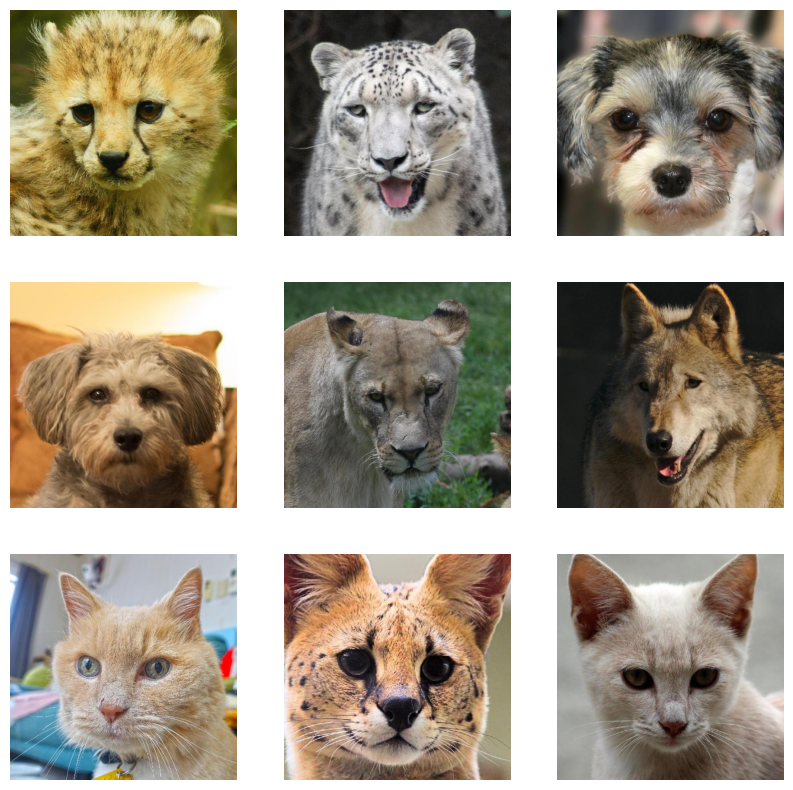

In [14]:
# visulaizing the tensor data into image
n_rows =3
n_cols=3

f,axarr = plt.subplots(n_rows,n_cols,figsize=(10,10))

for row in range(n_rows):
  for col in range(n_cols):
    image=Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis("off")
plt.show()

In [38]:
# providing the hyperparameters

LR =1e-4
BATCH_SIZE=32
EPOCHS=4

In [16]:
# dataloader is used to divide the data into batches

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [35]:
# Building a Neuralnetwork architecture with an nn.Module

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)

        self.maxpool=nn.MaxPool2d(kernel_size=2)
        self.relu=nn.ReLU()
        self.flatten=nn.Flatten()
        self.linear=nn.Linear(in_features=128*16*16,out_features=128)
        self.output = nn.Linear(128,len(data_df["labels"].unique()))

    def forward(self,x):
        x=self.conv1(x)  # ->(32,126,126)
        x=self.maxpool(x) # ->(32,63,63)
        x=self.relu(x)

        x=self.conv2(x)  # ->(64,61,61)
        x=self.maxpool(x) # ->(64,30,30)
        x=self.relu(x)

        x=self.conv3(x)  # ->(128,28,28)
        x=self.maxpool(x) # ->(128,14,14)
        x=self.relu(x)

        x=self.flatten(x)
        x=self.relu(x)
        x=self.linear(x)
        x=self.relu(x)
        x=self.output(x)

        return x




In [18]:
# modified version for the previous nn
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3),     # (32, 126, 126) if input is (3,128,128)
            nn.ReLU(),
            nn.MaxPool2d(2),         # (32, 63, 63)

            nn.Conv2d(32, 64, 3),    # (64, 61, 61)
            nn.ReLU(),
            nn.MaxPool2d(2),         # (64, 30, 30)

            nn.Conv2d(64, 128, 3),   # (128, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2)          # (128, 14, 14)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*14*14, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



In [36]:
model=Net()

In [37]:
# summarizing the neural network model and analyzing the parameters
from torchsummary import summary
summary(model,input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
             ReLU-11                [-1, 32768]               0
           Linear-12                  [-1, 128]       4,194,432
             ReLU-13                  [-1, 128]               0
           Linear-14                   

In [24]:
# creating an loss and optimizer for the model
# Optimizer : it is an algorithm used in ml and dl to adjust a models internal parametres like weights and biases to minimize a loss function
# loss function : formula that measures the error between a ml models predicted and actual true value


criterion =nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=LR)

In [60]:
# building a training loop model
# storing the accuracy loss of an train and validation
total_loss_train_plot=[]
total_loss_validation_plot=[]
total_acc_train_plot=[]
total_acc_validation_plot=[]

for epoch in range(EPOCHS):
  train_loss=0
  train_acc=0
  val_loss=0
  val_acc=0
  model.train()
  for batch,(image,label) in enumerate(train_loader):
    optimizer.zero_grad()

    output=model(image)
    train_loss_batch=criterion(output,label)
    train_loss+=train_loss_batch.item()

    train_loss_batch.backward()

    train_acc_batch=(output.argmax(dim=1)==label).sum().item()
    train_acc+=train_acc_batch
    optimizer.step()

  with torch.inference_mode():
    model.eval()
    for batch,(image,label) in enumerate(val_loader):
      output=model(image)
      val_loss_batch=criterion(output,label)
      val_loss+=val_loss_batch

      val_acc_batch=(output.argmax(dim=1)==label).sum().item()
      val_acc+=val_acc_batch

  total_loss_train_plot.append(train_loss/len(train_loader))
  total_loss_validation_plot.append(val_loss/len(val_loader))

  total_acc_train_plot.append(train_acc/len(train_loader))
  total_acc_validation_plot.append(val_acc/len(val_loader))

  print(f"Epoch {epoch+1}/{EPOCHS}")
  print(f"Train Loss: {train_loss/len(train_loader)}")
  print(f"Train Accuracy: {train_acc/len(train_loader)}")
  print(f"Validation Loss: {val_loss/len(val_loader)}")
  print(f"Validation Accuracy: {val_acc/len(val_loader)}")




Epoch 1/4
Train Loss: 1.1007094967466575
Train Accuracy: 10.351274787535411
Validation Loss: 1.0999623537063599
Validation Accuracy: 10.56578947368421
Epoch 2/4
Train Loss: 1.1007095923167112
Train Accuracy: 10.351274787535411
Validation Loss: 1.1000032424926758
Validation Accuracy: 10.56578947368421
Epoch 3/4
Train Loss: 1.1007069865975097
Train Accuracy: 10.351274787535411
Validation Loss: 1.099961280822754
Validation Accuracy: 10.56578947368421
Epoch 4/4
Train Loss: 1.100709411307705
Train Accuracy: 10.351274787535411
Validation Loss: 1.0999339818954468
Validation Accuracy: 10.56578947368421


In [33]:
with torch.inference_mode():
    model.eval()
    test_loss = 0
    test_correct = 0
    total_samples = 0

    for batch, (image, label) in enumerate(test_loader):
        pred = model(image)

        # loss
        test_loss_batch = criterion(pred, label)
        test_loss += test_loss_batch.item()

        # accuracy
        predicted_classes = pred.argmax(dim=1)
        test_correct += (predicted_classes == label).sum().item()
        total_samples += label.size(0)

    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {test_correct/total_samples:.4f}")


Test Loss: 0.1540
Test Accuracy: 0.9545


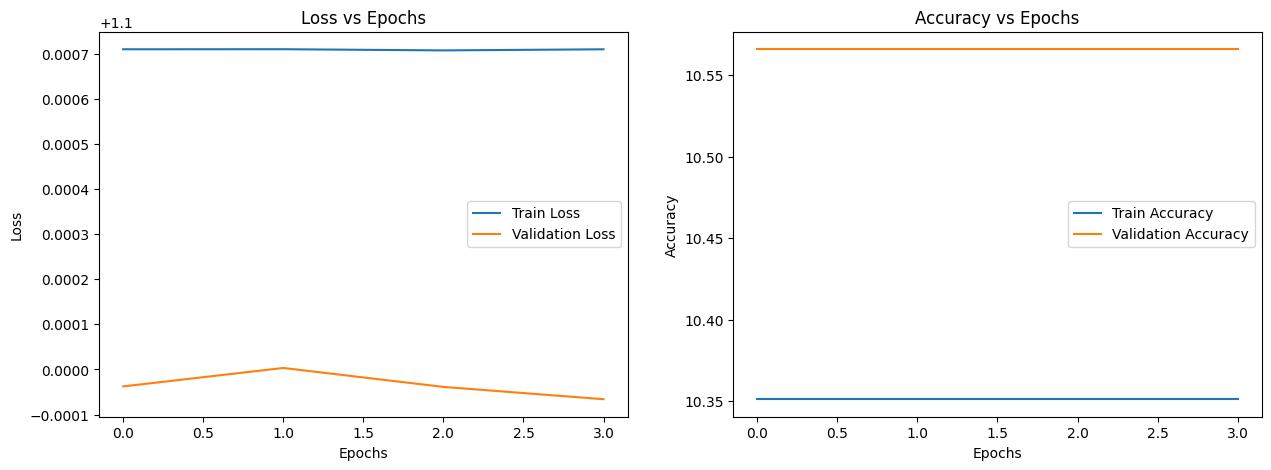

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(total_loss_train_plot, label='Train Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss vs Epochs')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Train Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy vs Epochs')
axs[1].legend()

plt.show()

In [58]:
# creating a image prediction function

def predict_image(image_path):
  image=Image.open(image_path).convert("RGB")
  image=transform(image)

  print(image.shape)
  image=image.unsqueeze(0)
  print(image.shape)

  output=model(image)
  output=torch.argmax(output,axis=1)

  return label_encoder.inverse_transform(output)[0]

In [62]:
predict_image("/content/Cat_November_2010-1a.jpg")

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])


'wild'

In [57]:
label_encoder.inverse_transform([2])

array(['wild'], dtype=object)